This notebooks include an implementation of the paper 

# **Initializations**
 =======================================================================================

We start by downloading all the side scripts that are needed to run the currente notebook!



In [1]:
#!wget ....
#!tar -xvf ...
!pip install torchvision==0.2.0

     |████████████████████████████████| 51kB 2.0MB/s 
  Found existing installation: torchvision 0.3.0
    Uninstalling torchvision-0.3.0:
      Successfully uninstalled torchvision-0.3.0


Then, we need to let the current ipython interpreter know that we are going to use some of the funcitionalities that are included in the "*adda*" folder we just obtained from  [here](https://).


In [0]:
import sys
sys.path.append('./adda')

Last, we need to initialize the notebook by importing all the side scripts containing the data loaders procedures as well as the train, adapt and eval procedures that will be later used to run the model adaptation solution.

In [3]:
import params
from utils import get_data_loader, init_model, init_random_seed, show_images
from core import eval_on_source_dset, eval_on_target_dset, train_on_source_dset, train_on_target_dset
from torchsummary import summary
import torch.nn.functional as F
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: ignored

To conclude the initialization procedures, we might want to fix a random seed for the sake of experimental reproducibility

In [0]:
# init random seed
init_random_seed(params.manual_seed)

use random seed: 3480


 # **Source Dataset**
 =======================================================================================

Let's define the network model we use to encode the image into a set of visual features as well as the classifier that maps from the visual features space to the digit label.
To do this we define the following network architecture which resembles the famous LeNet model.
![alt text](https://raw.githubusercontent.com/iN1k1/adda_domain_adaptation/master/images/source_encoder_classifier.png)

In [0]:
class LeNetEncoder(nn.Module):
    """LeNet encoder model for ADDA."""

    def __init__(self):
        """Init LeNet encoder."""
        super(LeNetEncoder, self).__init__()

        self.restored = False

        self.encoder = nn.Sequential(
            # 1st conv layer
            # input [1 x 28 x 28]
            # output [20 x 12 x 12]
            nn.Conv2d(1, 20, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            # 2nd conv layer
            # input [20 x 12 x 12]
            # output [50 x 4 x 4]
            nn.Conv2d(20, 50, kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU()
        )
        
        # A fully connected layer that linearizes the input feature maps
        # and generates an output of 500 neurons
        self.fc1 = nn.Linear(50 * 4 * 4, 500)

    # Forward pass function
    def forward(self, input):
        """Forward the LeNet."""
        conv_out = self.encoder(input)
        feat = self.fc1(conv_out.view(-1, 50 * 4 * 4))
        return feat


# Define the classification network that generates the label for the source dataset
class LeNetClassifier(nn.Module):
    """LeNet classifier model for ADDA."""

    def __init__(self):
        """Init LeNet encoder."""
        super(LeNetClassifier, self).__init__()
        
        # In this case, the classifier is a simple fully connected layer that 
        # maps the 500 input neurons (i.e., LeNetEncoder fc1 output)
        # to the 10 classes we are considering in our problem
        self.fc2 = nn.Linear(500, 10)

    def forward(self, feat):
        """Forward the LeNet classifier."""
        # Include a ReLU unit and a dropout layer with default probabilty
        out = F.dropout(F.relu(feat), training=self.training)
        out = self.fc2(out)
        return out


## Initialize network models
Let's instantiate and initialize the ```src_encoder``` and the ```src_classifier``` models. We do this within the ```init_model()``` wrapper which performs c**ustom weights initialization**, restores the model (if a valid path file is given) and **moves the network model to the GPU if CUDA is available** (check *adda/utils.py *for more details)


In [0]:
# Encoder network
src_encoder = init_model(net=LeNetEncoder(), restore=params.src_encoder_restore)

#Classifier network
src_classifier = init_model(net=LeNetClassifier(), restore=params.src_classifier_restore)

## Train the classifier on the source domain

We begin by generating the two objets responsibile of loading the **source dataset**. Specifically, ```src_data_loader``` will be used to load/read the** train split** while ```src_data_loader_eval``` will be used for the evaluation since it will contain the **test split of the source dataset.**

The ```get_data_loader()``` function will also download the dataset if this is not locally available.



In [0]:
# load source dataset
src_data_loader = get_data_loader(params.src_dataset)
src_data_loader_eval = get_data_loader(params.src_dataset, train=False)

## Useful visualizations

Before doing any trainining it is always a good idea to check what is the data we are loading and how it looks like.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 481.5, 481.5, -0.5)

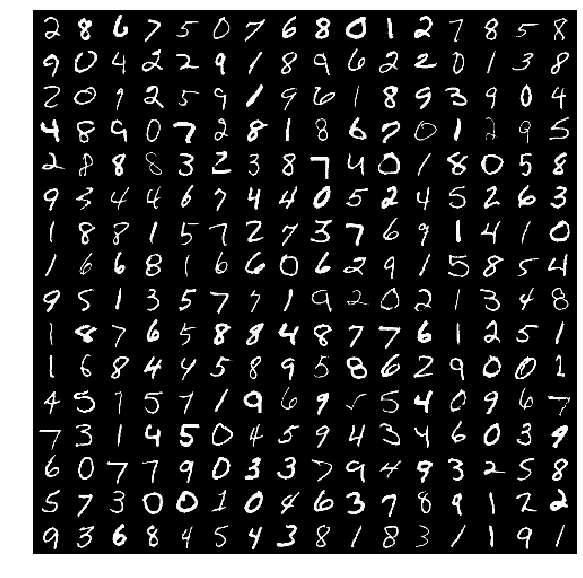

In [0]:
# Load a batch of images
im, _ = next(iter(src_data_loader))

# Use the torchvision package to generate a grid of images
grid_img = torchvision.utils.make_grid(im, nrow=int(np.sqrt(im.shape[0])))

# Plot the grid of images (first rearrange the dimensions which are different on PyTorch!)
plt.figure(figsize=(10,10), dpi=72)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')

Ok. Now that we are ok with the input data.. let's check the model and how the flow of the computations looks like. To use see this we are goint to use the ```torchsummary``` package and more precisely the ```summary``` function which will generate a table where each row corresponds to a layer in the network and the columns show information  on the output shape and on the number of paramters a specific layer will learn through training!



In [0]:
summary(src_encoder, input_size=im[0].size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
         MaxPool2d-2           [-1, 20, 12, 12]               0
              ReLU-3           [-1, 20, 12, 12]               0
            Conv2d-4             [-1, 50, 8, 8]          25,050
         Dropout2d-5             [-1, 50, 8, 8]               0
         MaxPool2d-6             [-1, 50, 4, 4]               0
              ReLU-7             [-1, 50, 4, 4]               0
            Linear-8                  [-1, 500]         400,500
Total params: 426,070
Trainable params: 426,070
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 1.63
Estimated Total Size (MB): 1.83
----------------------------------------------------------------


Let's also visualize the source classifier network but with a different command. We are going to use the simple ```print``` procedure to do this! PyTorch indeed exposes its modules also as strings which can then be used for printing..

In [0]:
print(src_classifier)

LeNetClassifier(
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


## Source Domain Training

Let's now train the encoder and the classifier on the source domain (or avoid doing it if the model has been initialized from previous training data..)! For each epoch we show the current percentage of visited batches and the number of iterations the system is able to perform at each second. 
Every 20 epochs (we can actually change this number and the number of training epochs in the params.py file) the model will be evaluated on the same train source dataset to see how good it performs on the training data.


In [0]:
if not (src_encoder.restored and src_classifier.restored and params.src_model_trained):
    src_encoder, src_classifier = train_on_source_dset(src_encoder, src_classifier, src_data_loader)
else:
    print('Source encoder and classifiers already trained and loaded from:\n{} and\n{}'.format(params.src_encoder_restore, params.src_classifier_restore))

Epoch 40/40: 100%|██████████| 235/235 [00:13<00:00, 18.05it/s]


Evaluating Model on the Source Dataset
Avg Loss = 0.03338185108682894, Avg Accuracy = 99.011667%
Saving model at: snapshots/ADDA-source-encoder-20.pth
Saving model at: snapshots/ADDA-source-classifier-20.pth
Evaluating Model on the Source Dataset
Avg Loss = 0.0045483735759068835, Avg Accuracy = 99.920000%
Saving model at: snapshots/ADDA-source-encoder-40.pth
Saving model at: snapshots/ADDA-source-classifier-40.pth
Saving model at: snapshots/ADDA-source-encoder-final.pth
Saving model at: snapshots/ADDA-source-classifier-final.pth



## Evaluation
We have trained the model on the source dataset. Let's see how good it performs on the same source dataset. To do this we run the model inference on the test split. 

In [0]:
# Eval encoder and classifier (whole network) on the source dataset
eval_on_source_dset(src_encoder, src_classifier, src_data_loader_eval)

Evaluating Model on the Source Dataset
Avg Loss = 0.026194193559058478, Avg Accuracy = 99.250000%


### Performance visualization

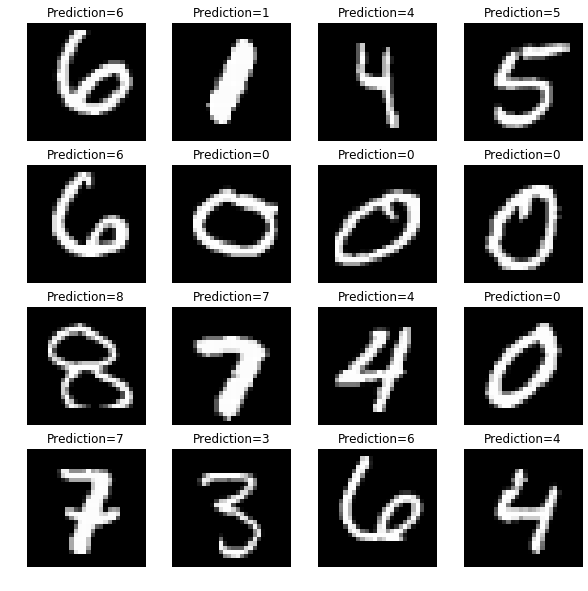

In [0]:
# Load a batch of random images from the test split of the source datasett
im, labels = next(iter(src_data_loader_eval))

# Get 16 images and correspondign predictions to visualize
im = im.numpy().transpose((0,2,3,1)).squeeze()[:16]
predictions = ['Prediction={}'.format(p) for p in labels.numpy()[:16].tolist()]

# Display images on a 4x4 grid
fig = plt.figure(figsize=(10,10), dpi=72)
show_images(im, cols=np.sqrt(len(im)), titles=predictions, fig=fig) 

# Domain Adaptation
By training our source encoder and classifier we have learnt a discriminative visual representation for the source domain data. Now, starting from the source encoder, we want to generate a different, yet similar, network which maps the input data from the target domain to the same feature space of the source domain. We can achieve this by exploiting a domain-adversarial (GAN-based) loss.
<br/>
**Let's now see how we can do it!**


## Define the distriminator network model
We start by defining a simple **discriminator network** which is takes as input the feature embedding generate by the visual encoder network. It is then responsible of emitting a binary decision which corresponds to its beliefs on which domain has been considered (i.e., does the input come from the source or the target domain?). By doing using such a discriminator with a GAN-based loss we aim that the discrimintor itself cannot reliably predict the domain of the source and target encoded examples.
<br/>
The structure of the network we are going to use for such a task should look like this one:
<br/>
![alt text](https://raw.githubusercontent.com/iN1k1/adda_domain_adaptation/master/images/discriminator.png)


In [0]:
class Discriminator(nn.Module):
    """Discriminator model for source domain."""

    def __init__(self, input_dims, hidden_dims, output_dims):
        """Init discriminator."""
        super(Discriminator, self).__init__()
        self.restored = False
        self.layer = nn.Sequential(
            nn.Linear(input_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, hidden_dims),
            nn.ReLU(),
            nn.Linear(hidden_dims, output_dims),
            nn.LogSoftmax()
        )

    def forward(self, input):
        """Forward the discriminator."""
        out = self.layer(input)
        return out


## Initialize the network models for adversarial adaptation 
We start by defining the soruce and the target visual encoders, namely ```src_encoder``` and ```tgt_encoder```, respectively. These will be responsible of generating the visual embeddings that are input to the discriminator network.

In [0]:
# Create/load the source and target visual encoders
src_encoder = init_model(net=LeNetEncoder(), restore=params.src_encoder_restore)
tgt_encoder = init_model(net=LeNetEncoder(), restore=params.tgt_encoder_restore)

# init weights of target encoder with those of source encoder if the target encoder has NOT been loaded from disk!
if not tgt_encoder.restored:
    tgt_encoder.load_state_dict(src_encoder.state_dict())


Restoring model from: /Volumes/2TB/GoogleDrive/Colab Notebooks/snapshots/ADDA-source-encoder-final.pth


Instantiate the a ```Discriminator``` object and init the model with a specifc configuration of input, hidden and output neurons.


In [0]:
critic = init_model(Discriminator(input_dims=params.d_input_dims, hidden_dims=params.d_hidden_dims,
                                  output_dims=params.d_output_dims), restore=params.d_model_restore)


## Load the target dataset 
Let's load the target dataset. We can do this by calling again the ```get_data_loader()```function with the target domain dataset name (i.e., USPS in our current example).

In [0]:
tgt_data_loader = get_data_loader(params.tgt_dataset)
tgt_data_loader_eval = get_data_loader(params.tgt_dataset, train=False)

# Need to reload the source data loader to avoid confusion when calling the data loader multiple times (image normalization have strange behaviors, check the documentation if needed)
#src_data_loader = get_data_loader(params.src_dataset)



## Useful visualizations

Let's check what is the data we are loading and how it looks like.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


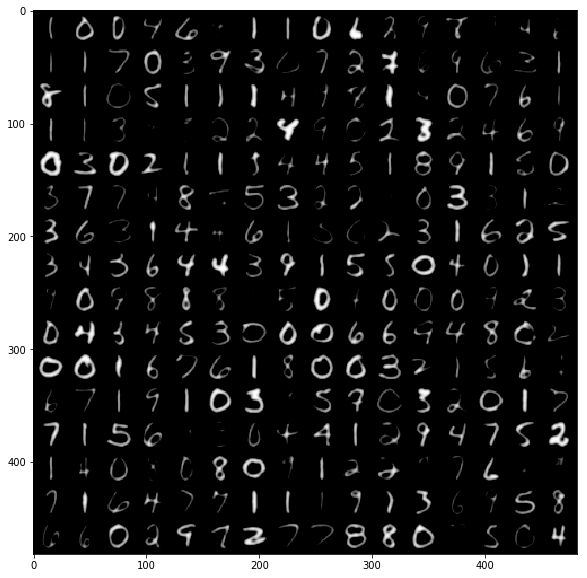

In [0]:
# Load a batch of images (from the target domain!)
im, _ = next(iter(tgt_data_loader))

# Use the torchvision package to generate a grid of images
grid_img = torchvision.utils.make_grid(im, nrow=int(np.sqrt(im.shape[0])))

# Plot the grid of images (first rearrange the dimensions which are different on PyTorch!)
plt.figure(figsize=(10,10), dpi=72)
plt.imshow(grid_img.permute(1, 2, 0))


Before proceeding with the real domain adaptation, we can run a sanity check and see if the target encoder and the discriminator architectures corresponds to the ones we have agreed upon.
<br/> 
We can use the either the ```summary()``` or the ```print()```functions (as we previously did!)

In [0]:
# Visualize the target encorer
im, _ = next(iter(tgt_data_loader))
summary(tgt_encoder, input_size=im[0].size())

# Visualize the discriminator
print(critic)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
         MaxPool2d-2           [-1, 20, 12, 12]               0
              ReLU-3           [-1, 20, 12, 12]               0
            Conv2d-4             [-1, 50, 8, 8]          25,050
         Dropout2d-5             [-1, 50, 8, 8]               0
         MaxPool2d-6             [-1, 50, 4, 4]               0
              ReLU-7             [-1, 50, 4, 4]               0
            Linear-8                  [-1, 500]         400,500
Total params: 426,070
Trainable params: 426,070
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 1.63
Estimated Total Size (MB): 1.83
----------------------------------------------------------------
Discriminator(
  (layer): Sequential(
    

## Target Domain Training (adaptation)
Let's now adapt the visual encoder on the target domain (or avoid doing it if the model has been initialized from a checkpoint)!
For each epoch we show the current percentage of visited batches and the number of iterations the system is able to perform at each second.


In [0]:
# Train target
if not (tgt_encoder.restored and critic.restored and params.tgt_model_trained):
    tgt_encoder = train_on_target_dset(src_encoder, tgt_encoder, critic, src_data_loader, tgt_data_loader)


Epoch 1/40:   0%|          | 0/30 [00:00<?, ?it/s]/Users/n1k1/anaconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
Epoch 40/40: 100%|██████████| 30/30 [00:02<00:00, 12.53it/s]


# Evaluation


## Load the trained models
To avoid any confusion within the notebook, we can start the evaluation by loading the trained/adapted models directly from the checkpoints.

In [0]:
# Load models
src_encoder = init_model(net=LeNetEncoder(), restore=params.src_encoder_restore)
src_classifier = init_model(net=LeNetClassifier(), restore=params.src_classifier_restore)
tgt_encoder = init_model(net=LeNetEncoder(), restore=params.tgt_encoder_restore)


Restoring model from: /Volumes/2TB/GoogleDrive/Colab Notebooks/snapshots/ADDA-source-encoder-final.pth
Restoring model from: /Volumes/2TB/GoogleDrive/Colab Notebooks/snapshots/ADDA-source-classifier-final.pth
Restoring model from: /Volumes/2TB/GoogleDrive/Colab Notebooks/snapshots/ADDA-target-encoder-final.pth


## Without adaptation test
To have a basic result to compare with, we can run the target domain evaluation by directly considering the visual features generated from the source encoder.
This will provide the results we can obtain by just directly applying the whole encoder+classifer model trained **ONLY** on the source domain!

In [0]:
# Evalute SOURCE encoder on test set of target dataset
eval_on_target_dset(src_encoder, src_classifier, tgt_data_loader_eval)


Avg Loss = 0.15242083463817835, Avg Accuracy = 95.806452%


## With adaptation test
Let's conclude the notebook by running the evaluation on the target domain with the **adapted** visual encoder. Remember that the classifier network is always the one that we have trained on the source domain!
We can do this since now we assume that the source and target encoders generate "identical" features for the same digit.

In [0]:
# Evalute TARGET encoder on test set of target dataset
eval_on_target_dset(tgt_encoder, src_classifier, tgt_data_loader_eval)

Avg Loss = 0.1447996476199478, Avg Accuracy = 97.150538%
